In [311]:
import numpy as np
import pandas as pd
import xgboost as xgb
import math
import re
import pickle
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel



data=pd.read_csv('train.csv',encoding="unicode_escape",error_bad_lines=False,low_memory=False)
np.set_printoptions(suppress=True)

test=pd.read_csv('test.csv',encoding="unicode_escape",error_bad_lines=False,low_memory=False)

data['purchase_stamp'] = [pd.Timestamp(time) for time in data['purchase_date'].values]
data['purchase_year'] = data['purchase_stamp'].apply(lambda x: x.year)
data['purchase_month'] = data['purchase_stamp'].apply(lambda x: x.month)
data['purchase_day'] = data['purchase_stamp'].apply(lambda x: x.day)
data['purchase_DayName'] = data['purchase_stamp'].apply(lambda d: d.weekday_name)
#data['purchase_DayOfYear'] = data['purchase_stamp'].apply(lambda d: d.dayofyear)
#data['purchase_WeekOfYear'] = data['purchase_stamp'].apply(lambda d: d.weekofyear)

data['release_stamp'] = [pd.Timestamp(time) for time in data['release_date'].values]
data['release_year'] = data['release_stamp'].apply(lambda x: x.year)
data['release_month'] = data['release_stamp'].apply(lambda x: x.month)
data['release_day'] = data['release_stamp'].apply(lambda x: x.day)
data['release_DayName'] = data['release_stamp'].apply(lambda d: d.weekday_name)
#data['release_DayOfYear'] = data['release_stamp'].apply(lambda d: d.dayofyear)
#data['release_WeekOfYear'] = data['release_stamp'].apply(lambda d: d.weekofyear)
data = data.drop(['purchase_date'],axis =1)
data = data.drop(['release_date'],axis =1)
data = data.drop(['purchase_stamp'],axis =1)
data = data.drop(['release_stamp'],axis =1)

test['purchase_stamp'] = [pd.Timestamp(time) for time in test['purchase_date'].values]
test['purchase_year'] = test['purchase_stamp'].apply(lambda x: x.year)
test['purchase_month'] = test['purchase_stamp'].apply(lambda x: x.month)
test['purchase_day'] = test['purchase_stamp'].apply(lambda x: x.day)
test['purchase_DayName'] = test['purchase_stamp'].apply(lambda d: d.weekday_name)
#test['purchase_DayOfYear'] = test['purchase_stamp'].apply(lambda d: d.dayofyear)
#test['purchase_WeekOfYear'] = test['purchase_stamp'].apply(lambda d: d.weekofyear)

test['release_stamp'] = [pd.Timestamp(time) for time in test['release_date'].values]
test['release_year'] = test['release_stamp'].apply(lambda x: x.year)
test['release_month'] = test['release_stamp'].apply(lambda x: x.month)
test['release_day'] = test['release_stamp'].apply(lambda x: x.day)
test['release_DayName'] = test['release_stamp'].apply(lambda d: d.weekday_name)
#test['release_DayOfYear'] = test['release_stamp'].apply(lambda d: d.dayofyear)
#test['release_WeekOfYear'] = test['release_stamp'].apply(lambda d: d.weekofyear)
test = test.drop(['purchase_date'],axis =1)
test = test.drop(['release_date'],axis =1)
test = test.drop(['purchase_stamp'],axis =1)
test = test.drop(['release_stamp'],axis =1)
#data.info()
#test.info()
data['play_or_not'] = np.where(data['playtime_forever']==0,0,1)

/Users/lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
/Users/lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
/Users/lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
/Users/lee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead


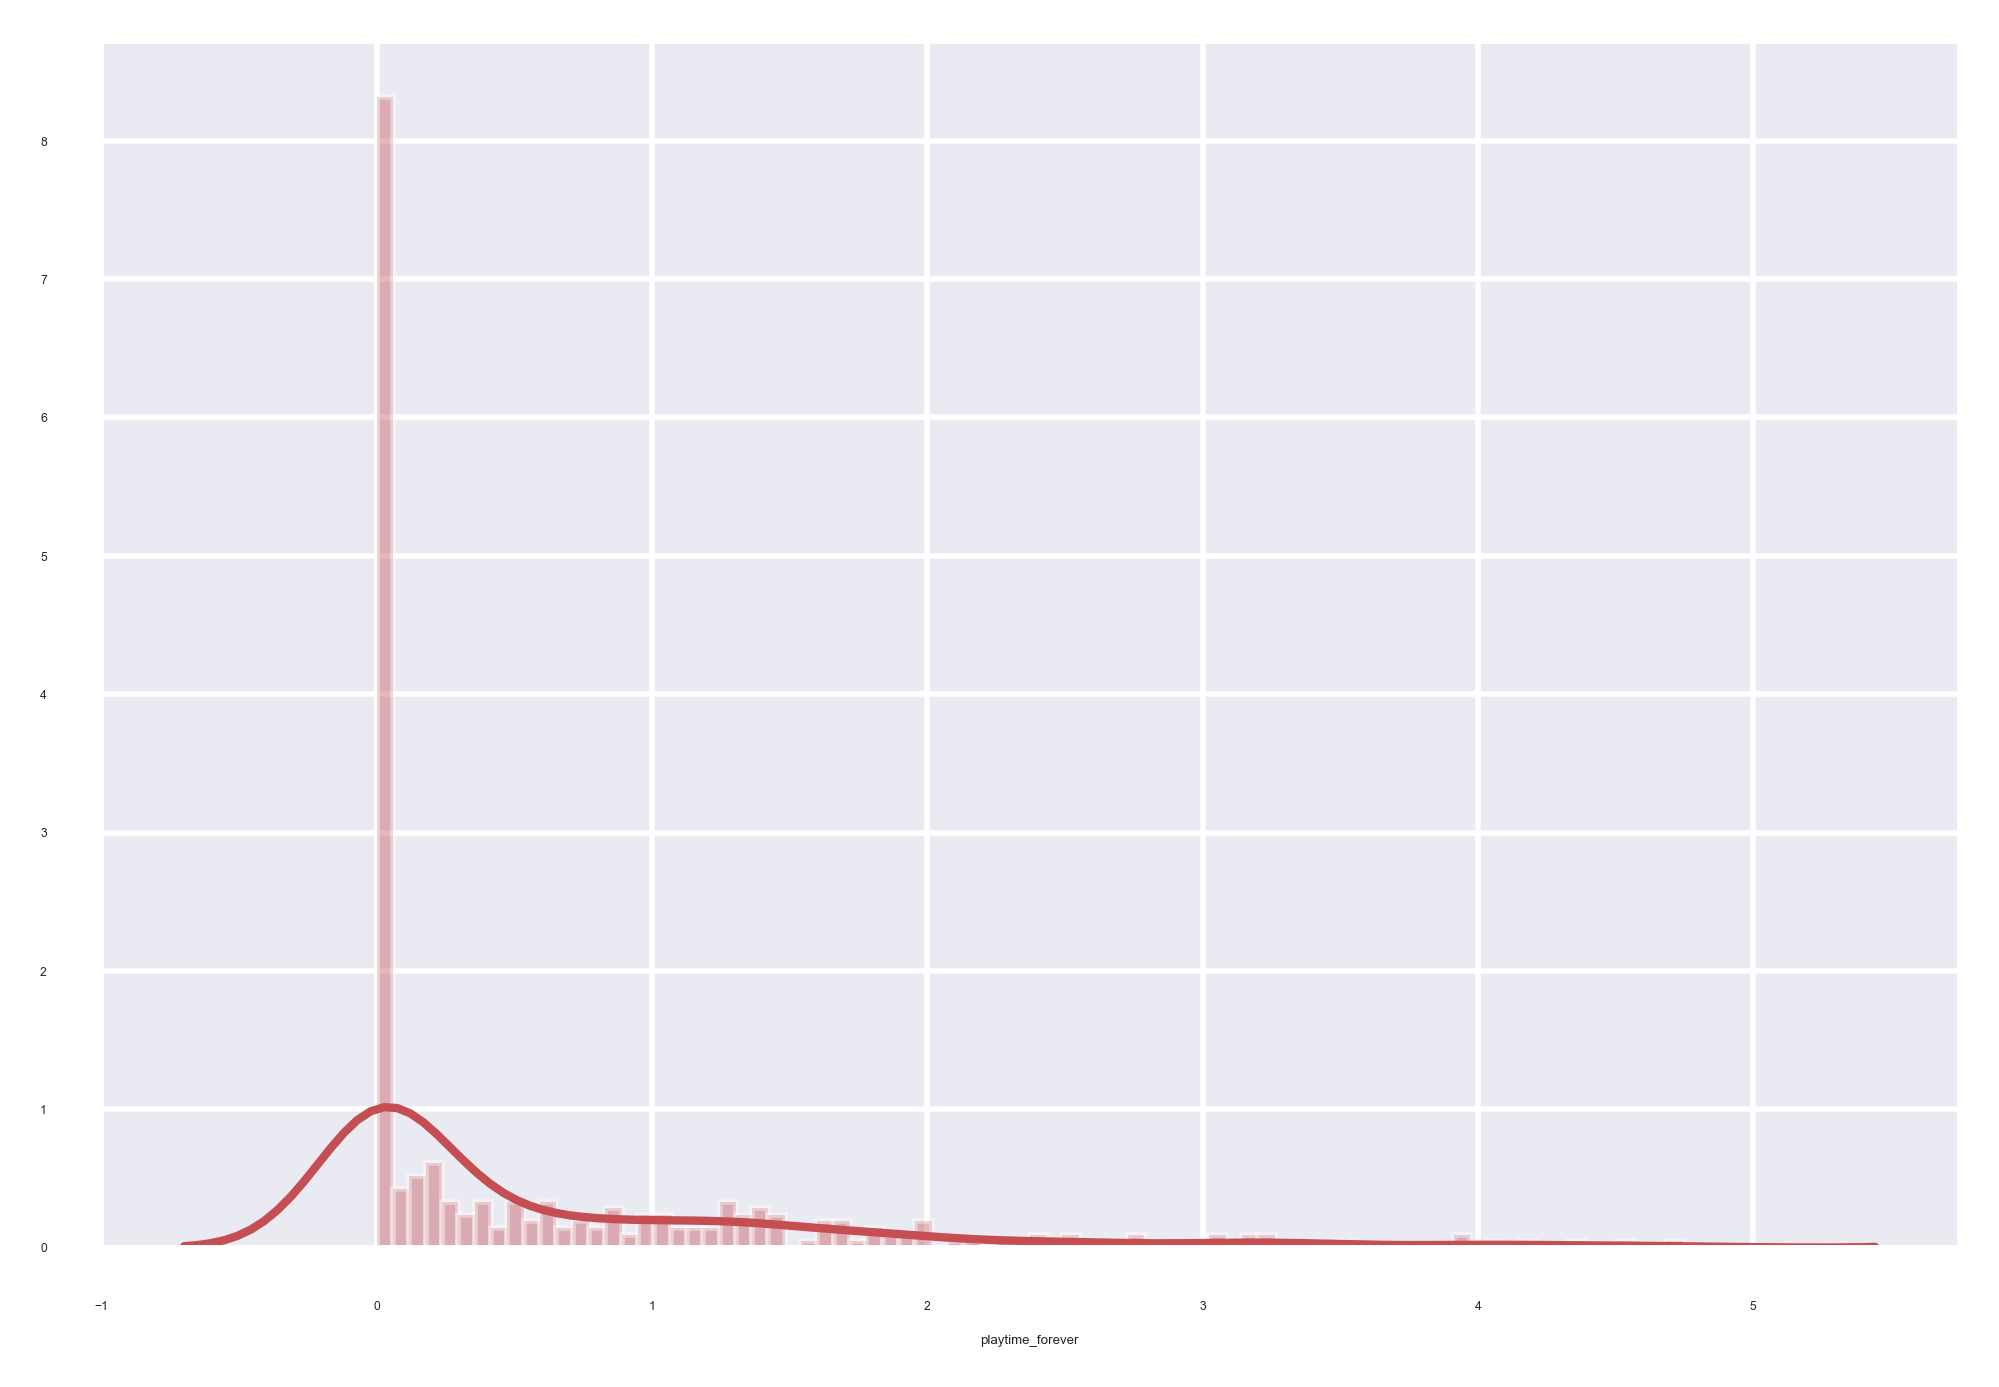

In [312]:
import seaborn as sns 
sns.set_palette("hls") #设置所有图的颜色，使用hls色彩空间
sns.distplot(np.log(data["playtime_forever"]+1),color="r",bins=80,kde=True)
plt.show()


Index(['Gen_Casual', 'Gen_Design & Illustration', 'Gen_Early Access',
       'Gen_Free to Play', 'Gen_Gore', 'Gen_Indie',
       'Gen_Massively Multiplayer', 'Gen_Nudity', 'Gen_RPG', 'Gen_Racing',
       ...
       'Tag_Voxel', 'Tag_Walking Simulator', 'Tag_War', 'Tag_Wargame',
       'Tag_Warhammer 40K', 'Tag_Western', 'Tag_World War I',
       'Tag_World War II', 'Tag_Zombies', 'Tag_eSports'],
      dtype='object', length=362)
['Gen_Design & Illustration', 'Gen_Early Access', 'Gen_Free to Play', 'Gen_Gore', 'Gen_Massively Multiplayer', 'Gen_Nudity', 'Gen_Racing', 'Gen_Sexual Content', 'Gen_Sports', 'Gen_Utilities', 'Gen_Violent', 'Cat_Commentary available', 'Cat_In-App Purchases', 'Cat_Includes Source SDK', 'Cat_Local Co-op', 'Cat_Local Multi-Player', 'Cat_MMO', 'Cat_Remote Play on Phone', 'Cat_Remote Play on TV', 'Cat_Remote Play on Tablet', 'Cat_SteamVR Collectibles', 'Cat_VR Support', 'Cat_Valve Anti-Cheat enabled', 'Tag_1980s', "Tag_1990's", 'Tag_2.5D', 'Tag_3D', 'Tag_3D Platform

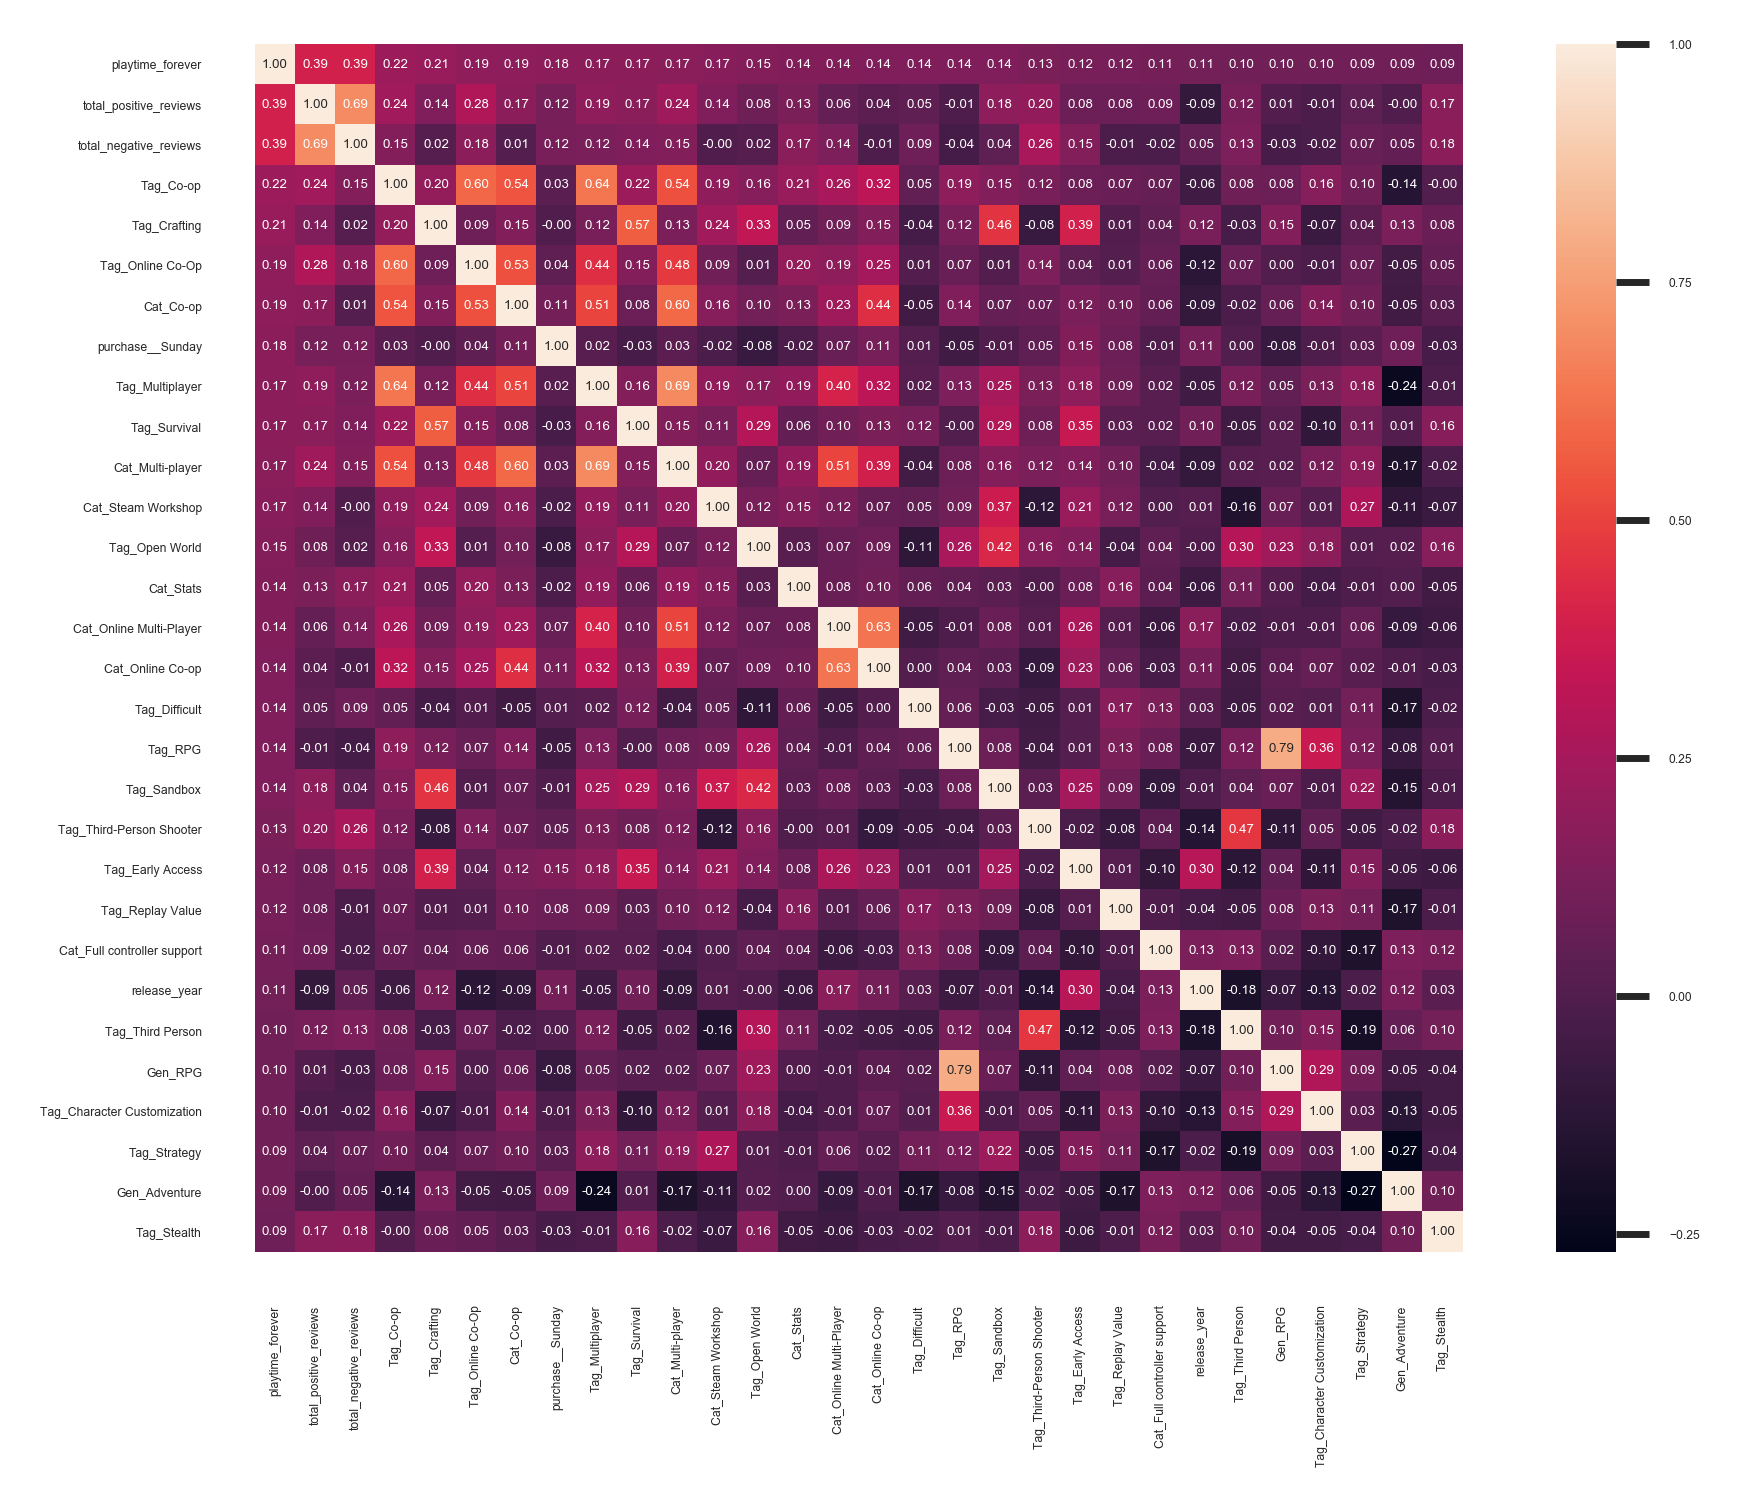

In [313]:
#data['playtime_forever']=np.sqrt(data["playtime_forever"])
#data['playtime_forever'] = np.log(data["playtime_forever"]+1)
small_x = data.copy()
y = data['playtime_forever']
Y=data['play_or_not']
data = data.drop(['playtime_forever'],axis =1)
data = data.drop(['play_or_not'],axis =1)
data = data.append(test)
data["positive_rate"]=data["total_positive_reviews"]/(data["total_positive_reviews"]+data["total_negative_reviews"])


genres = data['genres'].str.get_dummies(sep=',')
categories = data['categories'].str.get_dummies(sep=',')
tags = data['tags'].str.get_dummies(sep=',')
purchase_day = pd.get_dummies(data["purchase_DayName"],prefix="purchase_")
release_day = pd.get_dummies(data["release_DayName"],prefix="release_")
genres=genres.add_prefix('Gen_')
categories=categories.add_prefix('Cat_')
tags=tags.add_prefix('Tag_')
data=pd.concat([data,purchase_day],axis=1)
data=pd.concat([data,release_day],axis=1)
data=pd.concat([data,genres],axis=1)
data=pd.concat([data,categories],axis=1)
data=pd.concat([data,tags],axis=1)
data = data.drop(['genres'],axis =1)
data = data.drop(['categories'],axis =1)
data = data.drop(['tags'],axis =1)
data = data.drop(['purchase_DayName'],axis =1)
data = data.drop(['release_DayName'],axis =1)
data=data.fillna(0.0)

allfeature=data.columns[29:]
rare_feature=[]
many_feature=[]
sss=0
print(allfeature)
for i in allfeature:
    if((np.sum(data[i]==1)<25)):
        rare_feature.append(i)
        sss = sss+1
    elif(np.sum(data[i]==1)>280):
        many_feature.append(i)
        sss = sss+1
        

print(rare_feature)
print(many_feature)
print(sss)

def win2wp(data, df,fe):
    wp=0
    for i in fe:
        if(data[i]==1):
            wp=1
    return wp


def fill_Others(datadf,feature):
    
    wp = datadf.apply(win2wp, axis=1, df=datadf,fe=feature)
    return wp
data['Others']=0
data['Others'] = fill_Others(datadf=data,feature=rare_feature)
print(data['Others'])
#data = data.drop(['Others'],axis=1)
data = data.drop(rare_feature,axis =1)
data = data.drop(many_feature,axis =1)


#data=data.drop([ 'Tag_War', 'Tag_Walking Simulator', 'Tag_Visual Novel', 'Tag_Violent', 'Tag_VR', 'Tag_Turn-Based Strategy', 'Tag_Turn-Based', 'Tag_Third-Person Shooter', 'Tag_Third Person', 'Tag_Tactical', 'Tag_Survival Horror', 'Tag_Survival', 'Tag_Steampunk', 'Tag_Stealth', 'Tag_Space', 'Tag_Simulation', 'Tag_Side Scroller', 'Tag_Short', 'Tag_Shooter', 'Tag_Sandbox', 'Tag_Rogue-like', 'Tag_Retro', 'Tag_Replay Value', 'Tag_Realistic', 'Tag_RTS', 'Tag_Puzzle', 'Tag_Psychological Horror', 'Tag_Post-apocalyptic', 'Tag_Point & Click', 'Tag_Platformer', 'Tag_Pixel Graphics', 'Tag_Nudity', 'Tag_Mystery', 'Tag_Moddable', 'Tag_Medieval', 'Tag_Mature', 'Tag_Masterpiece', 'Tag_Massively Multiplayer', 'Tag_Magic', 'Tag_Kickstarter', 'Tag_Isometric', 'Tag_Horror', 'Tag_Historical', 'Tag_Hack and Slash', 'Tag_Gore', 'Tag_Futuristic', 'Tag_Funny', 'Tag_Free to Play', 'Tag_First-Person', 'Tag_Female Protagonist', 'Tag_Fantasy', 'Tag_Family Friendly', 'Tag_FPS', 'Tag_Exploration', 'Tag_Early Access', 'Tag_Dystopian', 'Tag_Difficult', 'Tag_Detective', 'Tag_Dark Fantasy', 'Tag_Dark', 'Tag_Cyberpunk', 'Tag_Cute', 'Tag_Crafting', 'Tag_Controller', 'Tag_Comedy', 'Tag_Colorful', 'Tag_Classic', 'Tag_Choices Matter', 'Tag_Character Customization', 'Tag_Casual', 'Tag_Building', 'Tag_Anime', 'Tag_Action RPG', 'Tag_2D', 'Ohters', 'Gen_Strategy', 'Gen_Simulation', 'Gen_Free to Play', 'Gen_Casual', 'Gen_Audio Production', 'Gen_Animation & Modeling', 'Cat_Steam Workshop', 'Cat_Steam Leaderboards', 'Cat_Stats', 'Cat_Shared/Split Screen', 'Cat_Remote Play on Tablet', 'Cat_Partial Controller Support', 'Cat_Online Multi-Player', 'Cat_Includes level editor', 'Cat_Cross-Platform Multiplayer', 'Cat_Captions available'],axis=1)

'''
x_train=data.iloc[:327,1:]
x_test=data.iloc[327:357,1:]
y_train = y.iloc[:327]
y_test = y.iloc[327:357]


Y_train = Y.iloc[:327]
Y_test = Y.iloc[327:357]




'''
x_train=data.iloc[:357,1:]
x_test=data.iloc[357:,1:]
y_train = y.iloc[:357]
y_test = y.iloc[357:]




Y_train = Y.iloc[:357]
Y_test = Y.iloc[357:]





co_data=x_train.copy()
co_data['playtime_forever'] = y_train
correlation = co_data.corr(method='pearson')
columns = correlation.nlargest(30, 'playtime_forever').index
columns
correlation_map = np.corrcoef(co_data[columns].values.T)
sns.set(font_scale=0.2)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)
plt.rcParams['savefig.dpi'] = 400 
plt.rcParams['figure.dpi'] = 400 
plt.show()




smallx_train = x_train.copy()
smallx_train["playtime_forever"]=y_train
smallx_train = smallx_train[smallx_train["playtime_forever"]!=0]
smally_train = smallx_train["playtime_forever"]
#smally_train = np.log(smally_train)
smallx_train = smallx_train.drop(['playtime_forever'],axis =1)

In [314]:
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
#categorical_features_indices = np.where(x_train.dtypes == np.object)[0]
#model2 = CatBoostRegressor(n_estimators=250,depth=6)
#model1 = CatBoostClassifier(n_estimators=150,depth=5)
model2 = xgb.XGBRegressor(n_estimators= 240, max_depth=8, learning_rate=0.01)
#model1 = xgb.XGBClassifier(n_estimators= 240, max_depth=5,learning_rate=0.01)
#model1 = RandomForestRegressor(n_estimators= 500, max_depth=20, min_samples_leaf=60, max_features=60)
#model1 = RandomForestClassifier(n_estimators= 500, max_depth=80, min_samples_leaf=60, max_features=60)
model1 = RandomForestClassifier(n_estimators= 75, max_depth=60, min_samples_leaf=20, max_features=60)
#model2 = RandomForestRegressor(n_estimators= 500, max_depth=60, min_samples_leaf=60, max_features=300)
model1.fit(x_train,Y_train)
model2.fit(x_train,y_train)

names = x_train.columns[0:]
print (sorted(zip(map(lambda x: round(x, 4), model2.feature_importances_), names), reverse=True))

'''
# select features using threshold
selection = SelectFromModel(model1, threshold=0.00001, prefit=True)
select_x_train = selection.transform(x_train)
# train model
model2 = xgb.XGBRegressor(n_estimators= 240, max_depth=8, learning_rate=0.01)
model2.fit(select_x_train, y_train)
# eval model
select_x_test = selection.transform(x_test)
'''




/Users/lee/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/lee/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[12:01:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[(0.426, 'release__Thursday'), (0.063, 'total_positive_reviews'), (0.0618, 'is_free'), (0.0568, 'Tag_2D'), (0.0405, 'Tag_Open World'), (0.0349, 'Gen_Action'), (0.0333, 'Tag_Exploration'), (0.0303, 'total_negative_reviews'), (0.0212, 'release_year'), (0.019, 'purchase_day'), (0.0175, 'release__Wednesday'), (0.0153, 'Tag_Fantasy'), (0.0122, 'Tag_RPG'), (0.011, 'release_month'), (0.0103, 'purchase__Saturday'), (0.0095, 'Tag_Crafting'), (0.0092, 'release_day'), (0.0091, 'release__Monday'), (0.0074, 'Tag_Strategy'), (0.0058, 'positive_rate'), (0.0058, 'Cat_Co-op'), (0.0057, 'purchase_year'), (0.0055, 'Tag_Third Person'), (0.0052, 'Tag_Sandbox'), (0.0052, 'Tag_Early Access'), (0.005, 'Tag_Building'), (0.0043, 'Tag_Hack and Slash'), (0.0042, 'Tag_Action RPG'), (0.0042, 'Cat_Steam Leaderboards'), (0.004, 'purchase_month'), (0.0035, 'price'), (0.0034, 'purchase__Thursday'), (0.003

'\n# select features using threshold\nselection = SelectFromModel(model1, threshold=0.00001, prefit=True)\nselect_x_train = selection.transform(x_train)\n# train model\nmodel2 = xgb.XGBRegressor(n_estimators= 240, max_depth=8, learning_rate=0.01)\nmodel2.fit(select_x_train, y_train)\n# eval model\nselect_x_test = selection.transform(x_test)\n'

In [315]:
from sklearn.metrics import classification_report

play_or_not=model1.predict(x_test)
#x_test['playtime_forever']=model2.predict(x_test)
x_test['playtime_forever']=model2.predict(x_test)
x_test['play_or_not']=play_or_not
x_test["id"]=data.iloc[357:,0]
x_test['playtime_forever'] = np.where(x_test['play_or_not']==0,0,x_test['playtime_forever'])
pred = pd.DataFrame(data=x_test,columns=['id','playtime_forever'])
pred['playtime_forever'] = np.where(pred['playtime_forever']>8,pred['playtime_forever']*1.4,pred['playtime_forever']*1.4)
pred[pred < 0] = 0
print(pred)
pred.to_csv('result.csv',index=False)





'''
pred = pd.DataFrame()
pred['play_or_not']=model1.predict(x_test)
#pred['playtime_forever'] = model2.predict(select_x_test)
pred['playtime_forever']=model2.predict(x_test)
y_test=y_test.reset_index(drop=True)
pred['True_time']=y_test
Train_pred = model2.predict(x_train)
#Train_pred = model2.predict(select_x_train)
#pred['True_time'] =np.exp(pred['True_time'])-1
#pred['True_time'] =np.square(pred['True_time'])
pred['playtime_forever'] = np.where(pred['play_or_not']==0,0,pred['playtime_forever'])
pred['playtime_forever'] = np.where(pred['playtime_forever']>8,pred['playtime_forever']*2,pred['playtime_forever']*1.3)
pred[pred < 0] = 0
#pred['playtime_forever'] =np.exp(pred['playtime_forever'])-1
#pred['playtime_forever'] =np.square(pred['playtime_forever'])
print(pred)
RMSE = math.sqrt(mean_squared_error(pred['True_time'], pred['playtime_forever']))
Train_RMSE = math.sqrt(mean_squared_error(y_train, Train_pred))
print("RMSE:"+str(RMSE))
print("Train_RMSE:"+str(Train_RMSE))
print(pred['play_or_not'].value_counts())
print(classification_report(Y_test, pred['play_or_not']))
pred.to_csv('result.csv',index=False)

'''

    id  playtime_forever
0    0          0.427681
1    1          0.000000
2    2          0.000000
3    3          0.000000
4    4          1.495688
5    5          0.000000
6    6          0.000000
7    7          0.000000
8    8          0.000000
9    9          1.111209
10  10          0.000000
11  11          0.000000
12  12          0.558837
13  13          9.282330
14  14          4.105239
15  15          0.000000
16  16          0.833800
17  17          0.313921
18  18          1.093423
19  19          0.000000
20  20          0.000000
21  21          2.093928
22  22          0.000000
23  23          0.823027
24  24          0.000000
25  25          0.000000
26  26          0.000000
27  27          1.183854
28  28          0.801535
29  29          2.241002
..  ..               ...
60  60          0.000000
61  61          0.240096
62  62          0.000000
63  63         19.706861
64  64          0.000000
65  65          0.663039
66  66          1.205794
67  67          0.000000


'\npred = pd.DataFrame()\npred[\'play_or_not\']=model1.predict(x_test)\n#pred[\'playtime_forever\'] = model2.predict(select_x_test)\npred[\'playtime_forever\']=model2.predict(x_test)\ny_test=y_test.reset_index(drop=True)\npred[\'True_time\']=y_test\nTrain_pred = model2.predict(x_train)\n#Train_pred = model2.predict(select_x_train)\n#pred[\'True_time\'] =np.exp(pred[\'True_time\'])-1\n#pred[\'True_time\'] =np.square(pred[\'True_time\'])\npred[\'playtime_forever\'] = np.where(pred[\'play_or_not\']==0,0,pred[\'playtime_forever\'])\npred[\'playtime_forever\'] = np.where(pred[\'playtime_forever\']>8,pred[\'playtime_forever\']*2,pred[\'playtime_forever\']*1.3)\npred[pred < 0] = 0\n#pred[\'playtime_forever\'] =np.exp(pred[\'playtime_forever\'])-1\n#pred[\'playtime_forever\'] =np.square(pred[\'playtime_forever\'])\nprint(pred)\nRMSE = math.sqrt(mean_squared_error(pred[\'True_time\'], pred[\'playtime_forever\']))\nTrain_RMSE = math.sqrt(mean_squared_error(y_train, Train_pred))\nprint("RMSE:"+st

In [160]:

#KFold
import numpy as np
from sklearn.model_selection import KFold
kf=KFold(n_splits=2)    # 定义分成几个组
# kf.get_n_splits(X)    # 查询分成几个组
print(kf)
for train_index,test_index in kf.split(X):
    print("Train Index:",train_index,",Test Index:",test_index)
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    #print(X_train,X_test,y_train,y_test)

KFold(n_splits=2, random_state=None, shuffle=False)


NameError: name 'X' is not defined